In [1]:
%pylab inline
import pandas as pd
import seaborn as sb

Populating the interactive namespace from numpy and matplotlib


#### Extend clicks_train and clicks_test with document_id and day

In [2]:
events = pd.read_csv("../generated/events.csv", usecols=['display_id', 'document_id', 'day'])
events.head()

,display_id,document_id,day
0,1,379743,14
1,2,1794259,14
2,3,1179111,14
3,4,1777797,14
4,5,252458,14


In [3]:
clicks_train = pd.read_csv("../download/clicks_train.csv")
clicks_train.count()

display_id    87141731
ad_id         87141731
clicked       87141731
dtype: int64

In [4]:
clicks_train = pd.merge(events, clicks_train, on=['display_id'])
clicks_train.to_csv("../temp/clicks_train.csv", index=False)
clicks_train.count()

display_id     87141731
document_id    87141731
day            87141731
ad_id          87141731
clicked        87141731
dtype: int64

In [5]:
clicks_test = pd.read_csv("../download/clicks_test.csv", usecols = ['display_id', 'ad_id'])
clicks_test.count()

display_id    32225162
ad_id         32225162
dtype: int64

In [6]:
clicks_test = pd.merge(events, clicks_test, on=['display_id'])
clicks_test.to_csv("../temp/clicks_test.csv", index=False)
clicks_test.count()

display_id     32225162
document_id    32225162
day            32225162
ad_id          32225162
dtype: int64

In [7]:
del events

#### Are there common display_ids in train and tests data? - No

In [ ]:
print len(pd.merge(clicks_train, clicks_test, on=['display_id']))

#### Are there ad_ids not common for train and test data? - Yes: only 316035 / 381385 test = 316035 / 478950 train

In [ ]:
clicks_train_ad_id_unique = pd.DataFrame({'ad_id':clicks_train['ad_id'].unique()})
clicks_train_ad_id_unique.count()

In [ ]:
clicks_test_ad_id_unique = pd.DataFrame({'ad_id':clicks_test['ad_id'].unique()})
clicks_test_ad_id_unique.count()

In [ ]:
print len(pd.merge(clicks_train_ad_id_unique, clicks_test_ad_id_unique, on=['ad_id']))

In [ ]:
del clicks_train_ad_id_unique
del clicks_test_ad_id_unique

#### Do Clicks and Events hold disply_ids only for clicked ad sets? -Yes, and only one ad could be clicked

In [ ]:
clicksPerDisplay = pd.DataFrame({'clicks' : clicks_train.groupby('display_id')['clicked'].sum()}).reset_index()
clicksPerDisplay.count()  

In [ ]:
len(clicksPerDisplay[clicksPerDisplay['clicks']<>1])   # 0 => Events also holds only clicked display_id

In [ ]:
del clicksPerDisplay

#### How much ads are shown on a page? : 2 - 12

In [8]:
adsPerDisplay = pd.concat([  #train ant test have no common display_id
            pd.DataFrame({'adsPerDisplay' : clicks_train.groupby(['display_id'])['ad_id'].size()}).reset_index(),
            pd.DataFrame({'adsPerDisplay' : clicks_test.groupby(['display_id'])['ad_id'].size()}).reset_index() ])

adsPerDisplay['adsPerDisplay'].describe()  #each display shows from 2 up to 12 ads as expected

count    2.312013e+07
mean     5.162900e+00
std      1.841843e+00
min      2.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      6.000000e+00
max      1.200000e+01
Name: adsPerDisplay, dtype: float64

In [ ]:
adsPerDisplay.to_csv("../generated/adsPerDisplay.csv", index=False)

In [9]:
del adsPerDisplay

#### Are there never clicked ads? - Yes: those that never clicked in train clicks and are not in test clicks - 121,573 out of total 544,300

In [10]:
# %load "features/clicksPerAd.py"
def clicksPerAd(clicks):
    return pd.DataFrame({'clicks': clicks.groupby(['ad_id'])['clicked'].sum(),
                         'shows': clicks.groupby(['ad_id'])['clicked'].size(),
                         'clicksPerShows': clicks.groupby(['ad_id'])['clicked'].mean()
                        }).reset_index()

def clicksPerAdDay(clicks):
    return pd.DataFrame({'clicksPerShows': clicks.groupby(['ad_id', 'day'])['clicked'].mean()
                        }).reset_index()

In [11]:
clicksPerAd_train = clicksPerAd(clicks_train)
clicksPerAd_train.describe()   

,ad_id,clicks,clicksPerShows,shows
count,478950.000000,478950.000000,478950.000000,478950.000000
mean,267338.532068,35.232473,0.143224,181.943274
std,153950.278267,422.647600,0.217684,1910.689568
min,1.000000,0.000000,0.000000,1.000000
25%,133000.250000,0.000000,0.000000,2.000000
50%,268955.500000,1.000000,0.051724,5.000000
75%,398996.500000,3.000000,0.205882,19.000000
max,548019.000000,44824.000000,1.000000,211824.000000


In [24]:
len(clicksPerAd_train[clicksPerAd_train['shows']>100])

42667

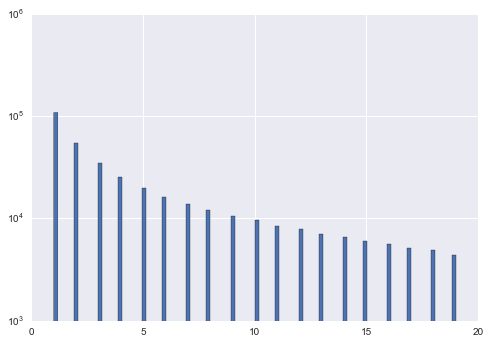

In [19]:
clicksPerAd_train[clicksPerAd_train['shows']<10].shows.hist(bins=100, log = True)

In [12]:
uniqueAds_test = pd.DataFrame({'shows_test': clicks_test.groupby(['ad_id'])['ad_id'].size()}).reset_index()
uniqueAds_test.describe() 

,ad_id,shows_test
count,381385.000000,381385.000000
mean,283535.058185,84.495096
std,168286.978632,789.903815
min,1.000000,1.000000
25%,128828.000000,1.000000
50%,289121.000000,3.000000
75%,432420.000000,9.000000
max,567073.000000,85392.000000


In [13]:
print len(pd.merge(clicksPerAd_train, uniqueAds_test, on=['ad_id']))

316035


In [ ]:
uniqueAds_never_clicked = pd.merge(clicksPerAd_train[clicksPerAd_train['clicks']==0], uniqueAds_test, how='left', on=['ad_id'])
uniqueAds_never_clicked = uniqueAds_never_clicked[uniqueAds_never_clicked['shows_test'].isnull()]
uniqueAds_never_clicked = uniqueAds_never_clicked.rename(columns={'clicks': 'clicked'})
uniqueAds_never_clicked.count()

In [ ]:
uniqueAds_never_clicked['shows'].hist(bins = 100, log = True)

In [ ]:
print len((clicksPerAd_train['ad_id'].append(uniqueAds_test['ad_id'])).unique())

In [ ]:
uniqueAds_never_clicked.drop(['clicksPerShows', 'shows', 'shows_test'], axis=1).to_csv("../generated/uniqueAds_never_clicked.csv", index=False)
clicksPerAd_train.to_csv("../generated/clicks_shows_PerAd.csv", index=False)

del uniqueAds_never_clicked
del uniqueAds_test
del clicksPerAd_train

#### Clicks and shows per Ad and Day

In [ ]:
clicks_train = pd.read_csv("../temp/clicks_train.csv")

In [6]:
clicksPerAdDay_train = clicksPerAdDay(clicks_train)
clicksPerAdDay_train.count() 

ad_id             1633198
day               1633198
clicksPerShows    1633198
dtype: int64

In [8]:
clicksPerAdDay_train.to_csv("../generated/clicks_shows_PerAdDay.csv", index=False)

#### Clicks and shows per document_id

In [ ]:
clicksPerDoc_train = pd.DataFrame({'clicks': clicks_train.groupby(['document_id'])['clicked'].sum(),
                                  'shows': clicks_train.groupby(['document_id'])['clicked'].size(),
                                  'clicksPerShows': clicks_train.groupby(['document_id'])['clicked'].mean()
                                 }).reset_index()

clicksPerDoc_train.to_csv("../generated/clicks_shows_PerDoc.csv", index=False)

clicksPerDoc_train.describe() 

In [ ]:
del clicksPerDoc_train

In [ ]:
clicks_all = clicks_train.append(clicks_test)

In [ ]:
del clicks_test

In [ ]:
showsPerDoc_all = pd.DataFrame({ 'shows': clicks_all.groupby(['document_id']).size() }).reset_index()
showsPerDoc_all.describe() 

In [ ]:
showsPerDoc_all.to_csv("../generated/shows_PerDoc.csv", index=False)

#### Sum, mean and number of ad clicks by document_id, ad_id

In [ ]:
clicksPerDocAd_train = pd.DataFrame({'clicks': clicks_train.groupby(['document_id', 'ad_id'])['clicked'].sum(),
                                     'shows': clicks_train.groupby(['document_id', 'ad_id'])['clicked'].size(),
                                     'clicksPerShows': clicks_train.groupby(['document_id', 'ad_id'])['clicked'].mean()                                  
                                    }).reset_index()
clicksPerDocAd_train.describe()   

In [ ]:
showsPerAd_all = pd.DataFrame({ 'shows': clicks_all.groupby(['ad_id']).size()}).reset_index()
showsPerAd_all.describe()

In [ ]:
showsPerDocAd_all = pd.DataFrame({ 'shows': clicks_all.groupby(['document_id', 'ad_id']).size()}).reset_index()
showsPerDocAd_all.describe() 

In [ ]:
clicksPerDocAd_train[(clicksPerDocAd_train['clicksPerShows']>0)].describe()

In [ ]:
clicksPerDocAd_train[(clicksPerDocAd_train['clicksPerShows']>0)&(clicksPerDocAd_train['shows']>1)]['shows'].hist(bins=100, log=True)

In [ ]:
showsPerDocAd_all[showsPerDocAd_all['shows']>1].describe()

In [ ]:
showsPerDocAd_all[showsPerDocAd_all['shows']>1]['shows'].hist(bins=100, log=True)

In [ ]:
clicksPerDocAd_train.to_csv("../generated/clicks_shows_PerDocAd_train.csv", index=False)
del clicksPerDocAd_train

In [ ]:
showsPerAd_all.to_csv("../generated/shows_PerAd_all.csv", index=False)
del showsPerAd_all

In [ ]:
showsPerDocAd_all.to_csv("../generated/shows_PerDocAd_all.csv", index=False)
del showsPerDocAd_all

In [ ]:
del clicks_train
del clicks_all